参数高效微调

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoConfig, AutoModel, get_cosine_schedule_with_warmup

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
from tqdm.auto import tqdm

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_epochs = 5
patience = 5

training_record = {}

### load dataset

In [ ]:
# tokenizer，加载bert的分词器,uncased就是不区分大小写
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# dataset
dataset_sst2 = load_dataset(
    "parquet",
    data_files={
        "train": "./sst2/data/train-00000-of-00001.parquet",
        "validation": "./sst2/data/validation-00000-of-00001.parquet"
        })

# preprocessing
def collate_fn(batch):
    #对字符串文本，进行编码，变为id,longest就是最长，padding就是填充,truncation为True就是截断
    inputs = tokenizer([x["sentence"] for x in batch], padding="longest", truncation=True, return_tensors="pt", max_length=512)
    labels = torch.tensor([x["label"] for x in batch])
    return inputs, labels

train_loader = DataLoader(dataset_sst2["train"], batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(dataset_sst2["validation"], batch_size=32, collate_fn=collate_fn)


In [6]:
print(dataset_sst2)
print(dataset_sst2["train"][0])

DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 872
    })
})
{'idx': 0, 'sentence': 'hide new secretions from the parental units ', 'label': 0}


In [7]:
len(dataset_sst2["train"])

67349

In [ ]:
for inputs, label in train_loader:
    # print(type(inputs))
    # print(type(label))
    print(inputs)
    print(label)
    break

{'input_ids': tensor([[ 101, 2062, 8669,  ...,    0,    0,    0],
        [ 101, 2009, 1005,  ...,    0,    0,    0],
        [ 101, 2003, 1037,  ..., 5541, 2143,  102],
        ...,
        [ 101, 2980,  102,  ...,    0,    0,    0],
        [ 101, 2032, 2000,  ...,    0,    0,    0],
        [ 101, 2008, 2573,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}
tensor([1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 1])


### define evaluattion and training function

In [ ]:
def evaluate(model, val_loader):
    model.eval()
    val_loss = 0
    val_acc = 0
    with torch.no_grad():
        total_samples = 0 # 统计验证集总样本数量
        for inputs, labels in val_loader:
            inputs = {k: v.to(device) for k, v in inputs.items()} # 输入是一个字典，所以拿value
            labels = labels.to(device)
            probs = model(**inputs)
            loss = F.binary_cross_entropy(probs, labels.float()) # 求损失
            val_loss += loss.item()
            val_acc += ((probs > 0.5) == labels).sum().item() # 模型的预测结果与实际标签是否相等,求和得到预测正确数量
            total_samples += len(labels)

    val_loss /= len(val_loader)
    val_acc /= total_samples
    return val_loss, val_acc


def train(model, train_loader, val_loader, device, num_epochs=3, patience=3):
    # 将模型移动到指定设备
    model.to(device)

    # 定义优化器
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

    # 计算训练步数总数
    total_steps = num_epochs * len(train_loader)

    # 使用transformers库中的余弦学习率调度器进行学习率调整
    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.2 * total_steps), #前20%步，学习率提升
        num_training_steps=total_steps
    )

    # 提前停止训练的控制变量
    best_val_acc = -1
    cur = 0

    # 存储训练和验证指标的容器
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in tqdm(range(num_epochs)):
        # 进入训练模式
        model.train()
        train_loss = 0
        train_acc = 0
        total_samples = 0

        # 对训练数据进行迭代
        for inputs, labels in train_loader:
            # 将数据移动到指定设备
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = labels.to(device)

            # 前向传播并计算损失
            optimizer.zero_grad()
            probs = model(**inputs) # **代表字典解包，inputs 中的键名必须与模型 forward() 方法的参数名完全一致
            loss = F.binary_cross_entropy(probs, labels.float()) 
            loss.backward()
            optimizer.step()
            scheduler.step()

            # 收集指标
            train_loss += loss.item()
            train_acc += ((probs > 0.5) == labels).sum().item()
            total_samples += len(labels)

        train_loss /= len(train_loader)
        train_acc  /= total_samples

        # 进行验证
        val_loss, val_acc = evaluate(model, val_loader)

        # 记录指标
        print(f"epoch {epoch}: train_loss {train_loss:.4f}, train_acc {train_acc:.4f}, val_loss {val_loss:.4f}, val_acc {val_acc:.4f}")
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # 提前停止训练
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            cur = 0
        else:
            cur += 1
        if cur >= patience:
            print("提前停止训练")
            break

    return history

### a function to check the parameters that could be fintuned

In [ ]:
def human_readable_count(n):
    # 定义一个函数，用于处理可读性较好的数字格式,模型参数量
    if n < 1_000:
        return f"{n}"
    elif n < 1_000_000:
        return f"{n/1_000:.2f}K"  # 如果在千到百万之间，使用K表示
    elif n < 1_000_000_000:
        return f"{n/1_000_000:.2f}M"  # 如果在百万到十亿之间，使用M表示
    else:
        return f"{n/1_000_000_000:.2f}B"  # 如果大于十亿，使用B表示


def count_parameters(model):
    # 统计模型参数
    total_params = sum(p.numel() for p in model.parameters())  # 总参数数量
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)  # 可训练参数数量
    frozen_params = total_params - trainable_params  # 冻结参数数量

    # 输出参数数量
    print(f"Total Parameters:\t{human_readable_count(total_params):>8}")  
    print(f"Frozen Parameters:\t{human_readable_count(frozen_params):>8}")  
    print(f"Trainable Parameters:\t{human_readable_count(trainable_params):>8}\t{trainable_params / total_params:.2%}")  

In [ ]:
import matplotlib.pyplot as plt  

def plot_training_record(training_record, metric_name="val_acc"):
    plt.figure(figsize=(12, 6))  
    for method_name, record in training_record.items():  
        metrics = record[metric_name]  
        plt.plot(range(len(metrics)), metrics, label=method_name) 

    plt.xlabel("Epoch") 
    plt.ylabel("Validation Accuracy") 
    plt.legend() 
    plt.grid()  
    plt.show() 

In [12]:
#bert-base-uncased的uncased不区分大小写的意思
bert_model=AutoModel.from_pretrained("bert-base-uncased")
print(bert_model)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

## A Frozen pretrained Bert as a feature extractor  将预训练过的Bert冻结作为特征提取器

In [ ]:
# 定义一个继承自 nn.Module 的 FrozenBert 类
class FrozenBert(nn.Module):
    def __init__(self):
      super().__init__()
      # 加载预训练的BERT模型（不区分大小写的版本），因为下载模型，需要等待一下
      self.model = AutoModel.from_pretrained("bert-base-uncased")

      # 添加一个线性分类器
      self.classifier = nn.Linear(self.model.config.hidden_size, 1)

      for param in self.model.parameters():
          param.requires_grad = False

    # 定义前向传播过程
    def forward(self, **inputs):
      # 获取BERT的最后一个隐藏层的输出，并选中序列的第一项（[CLS] token）,肯定不可以选最后一个，可以尝试平均,(bs,seq_len,hidden_dim)
      feature = self.model(**inputs).last_hidden_state[:, 0, :]
      # 将特征通过线性分类器获取对数几率
      logits = self.classifier(feature)
      # 应用sigmoid激活函数并将结果集中成一维输出,squeeze把为1的维度消去
      return torch.sigmoid(logits).squeeze()


# 实例化FrozenBert类，创建一个模型对象
frozen_bert = FrozenBert()
print(frozen_bert)
# for name, param in frozen_bert.named_parameters(): # 打印模型参数
#   print(name, param.shape)

count_parameters(frozen_bert)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


FrozenBert(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

In [ ]:
training_record["Frozen"] = train(frozen_bert, train_loader, val_loader, device, num_epochs=num_epochs, patience=patience)

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 0: train_loss 0.6952, train_acc 0.5065, val_loss 0.6767, val_acc 0.5287
epoch 1: train_loss 0.6531, train_acc 0.6116, val_loss 0.6296, val_acc 0.6697
epoch 2: train_loss 0.6232, train_acc 0.6836, val_loss 0.5997, val_acc 0.7523
epoch 3: train_loss 0.6065, train_acc 0.7250, val_loss 0.5875, val_acc 0.7729
epoch 4: train_loss 0.6013, train_acc 0.7322, val_loss 0.5855, val_acc 0.7752


In [16]:
training_record

{'Frozen': {'train_loss': [0.6952418185752814,
   0.6531180764886942,
   0.623188104793748,
   0.6064946570475708,
   0.6012504652390287],
  'train_acc': [0.5065257093646528,
   0.6115903725370829,
   0.6835587759283731,
   0.724984780768831,
   0.7322306196083089],
  'val_loss': [0.6767006388732365,
   0.6296201667615345,
   0.5997158757277897,
   0.5875364414283207,
   0.585470478449549],
  'val_acc': [0.5286697247706422,
   0.6697247706422018,
   0.7522935779816514,
   0.7729357798165137,
   0.7752293577981652]}}

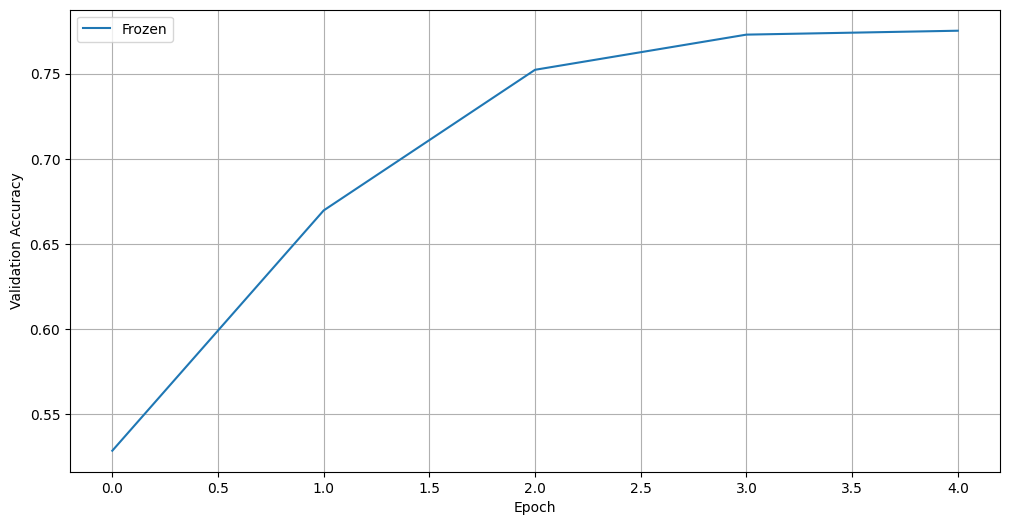

In [17]:
plot_training_record(training_record, metric_name="val_acc")

## Fully Finetuning

In [ ]:
class FullyFinetunedBert(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = AutoModel.from_pretrained("bert-base-uncased")  # 从预训练模型加载BERT
        self.classifier = nn.Linear(self.model.config.hidden_size, 1)  # 添加线性分类器，输出维度为1

    def forward(self, **inputs):
        feature = self.model(**inputs).last_hidden_state[:, 0, :]  # 获取特征向量
        logits = self.classifier(feature)  # 应用分类器
        return torch.sigmoid(logits).squeeze()  # 使用sigmoid激活函数并压缩维度


# 加载预训练模型
fully_fine_tuned_bert = FullyFinetunedBert()
print('-'*50)
print(fully_fine_tuned_bert)
print('-'*50)
# 检查参数数量
count_parameters(fully_fine_tuned_bert)


training_record["Fully Fine-Tuning"] = train(
    fully_fine_tuned_bert,
    train_loader,
    val_loader,
    device,
    num_epochs=num_epochs,
    patience=patience
    )  

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


--------------------------------------------------
FullyFinetunedBert(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 0: train_loss 0.3154, train_acc 0.8467, val_loss 0.2438, val_acc 0.9117
epoch 1: train_loss 0.1440, train_acc 0.9474, val_loss 0.2239, val_acc 0.9186
epoch 2: train_loss 0.0940, train_acc 0.9683, val_loss 0.2474, val_acc 0.9163
epoch 3: train_loss 0.0615, train_acc 0.9793, val_loss 0.2573, val_acc 0.9232
epoch 4: train_loss 0.0443, train_acc 0.9853, val_loss 0.2771, val_acc 0.9220


In [19]:
del fully_fine_tuned_bert

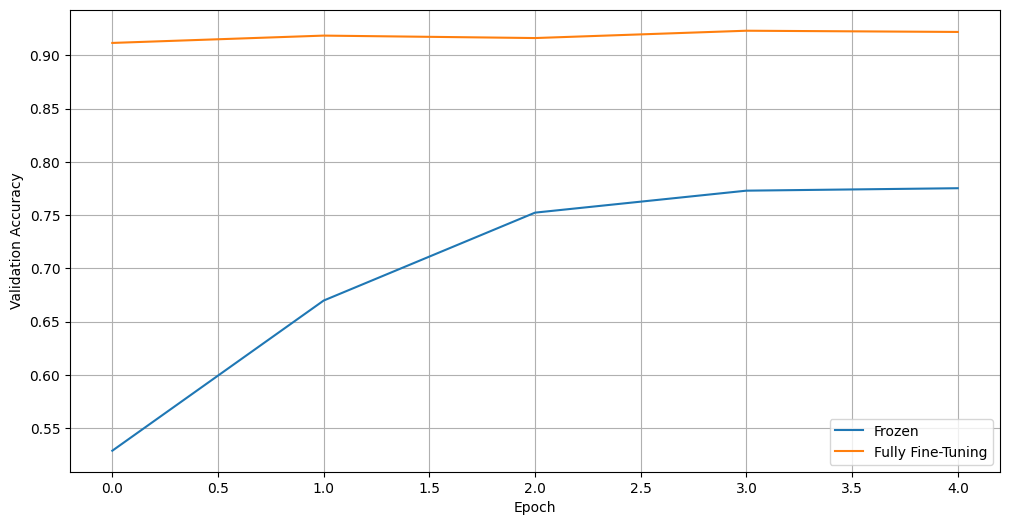

In [ ]:
plot_training_record(training_record, metric_name="val_acc")

## BitFit

BitFit（论文：BitFit: Simple Parameter-efficient Fine-tuning or Transformer-based Masked Language-models）是一种稀疏的微调方法，它训练时只更新bias的参数或者部分bias参数。

In [ ]:
class BitFitBert(nn.Module):
    def __init__(self):
        super().__init__()
        # 加载预训练模型
        self.model = AutoModel.from_pretrained("bert-base-uncased")
        self.classifier = nn.Linear(self.model.config.hidden_size, 1)

        # 冻结除所有偏置项之外的参数
        for name, param in self.model.named_parameters():
            if "bias" not in name:
                param.requires_grad = False

    def forward(self, **inputs):
        feature = self.model(**inputs).last_hidden_state[:, 0, :]  # 获取特征向量
        logits = self.classifier(feature)  # 应用分类器
        return torch.sigmoid(logits).squeeze()  # 使用sigmoid激活函数并压缩维度


# 加载预训练模型
bitfit_bert = BitFitBert()
print('-'*50)
print(bitfit_bert)
print('-'*50)
# 检查参数数量
count_parameters(bitfit_bert)

training_record["BitFit"] = train(bitfit_bert, train_loader, val_loader, device, num_epochs=num_epochs, patience=patience)  # 对BitFitBert进行训练，并将训练记录保存在training_record中

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


--------------------------------------------------
BitFitBert(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNo

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 0: train_loss 0.6653, train_acc 0.5953, val_loss 0.5656, val_acc 0.8073
epoch 1: train_loss 0.3942, train_acc 0.8487, val_loss 0.3359, val_acc 0.8612
epoch 2: train_loss 0.3343, train_acc 0.8606, val_loss 0.3180, val_acc 0.8658
epoch 3: train_loss 0.3245, train_acc 0.8653, val_loss 0.3120, val_acc 0.8716
epoch 4: train_loss 0.3206, train_acc 0.8679, val_loss 0.3115, val_acc 0.8716


In [22]:
del bitfit_bert

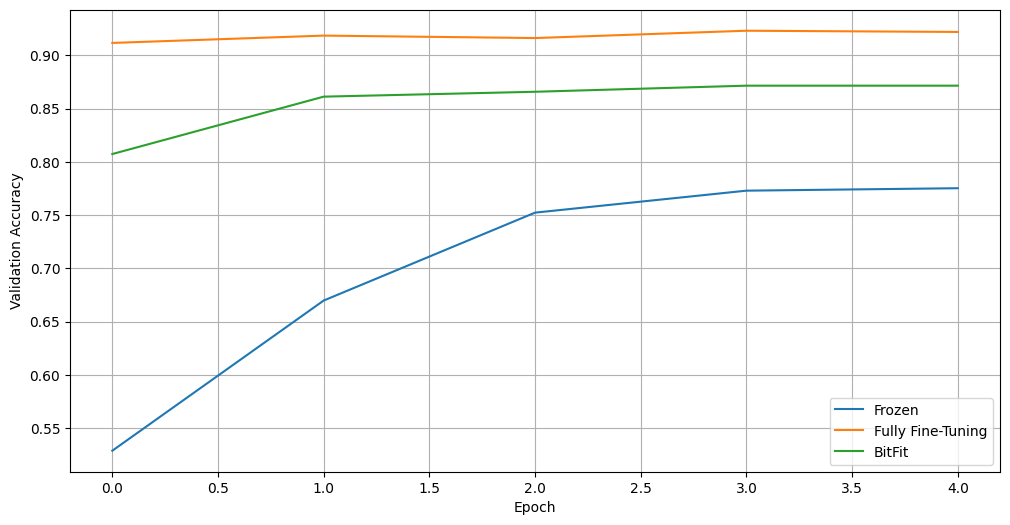

In [ ]:
plot_training_record(training_record, metric_name="val_acc")

## P-Tuning & P-Tuning v2 & Prefix Tuning

|方法|参数重整化| 微调参数所在层 | 适配下游任务 |
|-|-|-|-|
|P-tuning|MLP + LSTM 或者 MLP| embedding 层| 使得GPT做NLU |
|P-tuning v2|不使用| 每一层 | NLG & NLU |
|prefix tuning|MLP| 每一层 | NLG |

In [ ]:
import torch
import torch.nn as nn
prefix_tokens = nn.Parameter(torch.zeros(20, 768))
prefix_tokens = prefix_tokens.unsqueeze(0).expand(32, -1, -1) # 给每个样本都增加一个（20, 768）
print(prefix_tokens.shape)

torch.Size([32, 20, 768])


In [ ]:
import torch
import torch.nn as nn
from transformers import AutoModel
import torch.nn.functional as F
import numpy as np

class PTuningBert(nn.Module):
    def __init__(self, num_virtual_tokens=20, reparameterization_type="MLP"):
        super().__init__()
        # 加载预训练模型
        self.model = AutoModel.from_pretrained("bert-base-uncased")
        self.classifier = nn.Linear(self.model.config.hidden_size, 1)

        # 冻结除分类器层之外的参数
        for param in self.model.parameters():
            param.requires_grad = False

        hidden_size = self.model.config.hidden_size
        self.num_virtual_tokens = num_virtual_tokens #虚拟token数目
        # 定义一个可学习的参数，作为虚拟提示的初始值，其形状为(num_virtual_tokens, hidden_size)
        self.prompt = nn.Parameter(torch.zeros(self.num_virtual_tokens, hidden_size))
        print(self.prompt.shape)
        # 重新参数化,根据传入的reparameterization_type参数，初始化不同的重新参数化头部
        self.reparameterization_type = reparameterization_type
        if reparameterization_type == "MLP":
            self.mlp_head = nn.Sequential(
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, hidden_size),
            )
        elif reparameterization_type == "LSTM":
            self.lstm_head = nn.LSTM(
                input_size=hidden_size,
                hidden_size=hidden_size,
                num_layers=2,
                bidirectional=True,
                batch_first=True,
            )
            self.mlp_head = nn.Sequential(
                nn.Linear(hidden_size * 2, hidden_size * 2),
                nn.ReLU(),
                nn.Linear(hidden_size * 2, hidden_size),
            )

    def forward(self, input_ids, attention_mask, **args):
        # 获取输入的批次大小
        batch_size = input_ids.size(0)
        # 将虚拟提示扩展到与输入相同批次大小 (batch_size,num_virtual_tokens,hidden_size)
        prompt = self.prompt.unsqueeze(0).expand(batch_size, -1, -1)

        # 根据选择的重新参数化类型，对虚拟提示进行处理
        if self.reparameterization_type == "MLP":
            prompt = self.mlp_head(prompt) #(batch_size,num_virtual_tokens,hidden_size)
        elif self.reparameterization_type == "LSTM":
            prompt, _ = self.lstm_head(prompt)
            prompt = self.mlp_head(prompt)

        # 将虚拟提示与输入的嵌入层输出连接，形成扩展的输入嵌入
        embedding_output = self.model.embeddings(input_ids)
        extended_inputs_embeds = torch.cat([prompt, embedding_output], dim=1) #在seq_len进行拼接
        extended_attention_mask = torch.cat([
            torch.ones(batch_size, self.num_virtual_tokens).to(input_ids.device),
            attention_mask
        ], dim=1) # 掩码要同步改变，虚拟token对应的mask值都是1

        # 将扩展的输入嵌入和注意力掩码输入BERT模型
        outputs = self.model(inputs_embeds=extended_inputs_embeds, attention_mask=extended_attention_mask)
        # 获取经过BERT模型处理后的特定位置的特征，即虚拟提示之后的第一个位置，等价于原来的第0个位置
        feature = outputs.last_hidden_state[:, self.num_virtual_tokens, :]

        logits = self.classifier(feature)
        return torch.sigmoid(logits).squeeze()


# 加载预训练模型
ptuning_bert = PTuningBert()
# ptuning_bert = PTuningBert(reparameterization_type='LSTM')
print('-'*50)
print(ptuning_bert)
print('-'*50)
# 记录参数数量
# def count_parameters(model):
#     return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(ptuning_bert)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


torch.Size([20, 768])
--------------------------------------------------
PTuningBert(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)

In [26]:
for idx, (key, value) in enumerate(ptuning_bert.named_parameters()):
    print(f"{key:^50}: {str(value.shape)}")


                      prompt                      : torch.Size([20, 768])
     model.embeddings.word_embeddings.weight      : torch.Size([30522, 768])
   model.embeddings.position_embeddings.weight    : torch.Size([512, 768])
  model.embeddings.token_type_embeddings.weight   : torch.Size([2, 768])
        model.embeddings.LayerNorm.weight         : torch.Size([768])
         model.embeddings.LayerNorm.bias          : torch.Size([768])
model.encoder.layer.0.attention.self.query.weight : torch.Size([768, 768])
 model.encoder.layer.0.attention.self.query.bias  : torch.Size([768])
 model.encoder.layer.0.attention.self.key.weight  : torch.Size([768, 768])
  model.encoder.layer.0.attention.self.key.bias   : torch.Size([768])
model.encoder.layer.0.attention.self.value.weight : torch.Size([768, 768])
 model.encoder.layer.0.attention.self.value.bias  : torch.Size([768])
model.encoder.layer.0.attention.output.dense.weight: torch.Size([768, 768])
model.encoder.layer.0.attention.output.dense.bias 

In [ ]:
training_record["P-Tuning"] = train(ptuning_bert, train_loader, val_loader, device, num_epochs=num_epochs, patience=patience)

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 0: train_loss 0.6564, train_acc 0.5982, val_loss 0.6112, val_acc 0.6548
epoch 1: train_loss 0.5521, train_acc 0.7253, val_loss 0.5500, val_acc 0.7305
epoch 2: train_loss 0.5051, train_acc 0.7567, val_loss 0.5164, val_acc 0.7603
epoch 3: train_loss 0.4875, train_acc 0.7682, val_loss 0.5097, val_acc 0.7569
epoch 4: train_loss 0.4816, train_acc 0.7711, val_loss 0.5089, val_acc 0.7580


In [28]:
del ptuning_bert

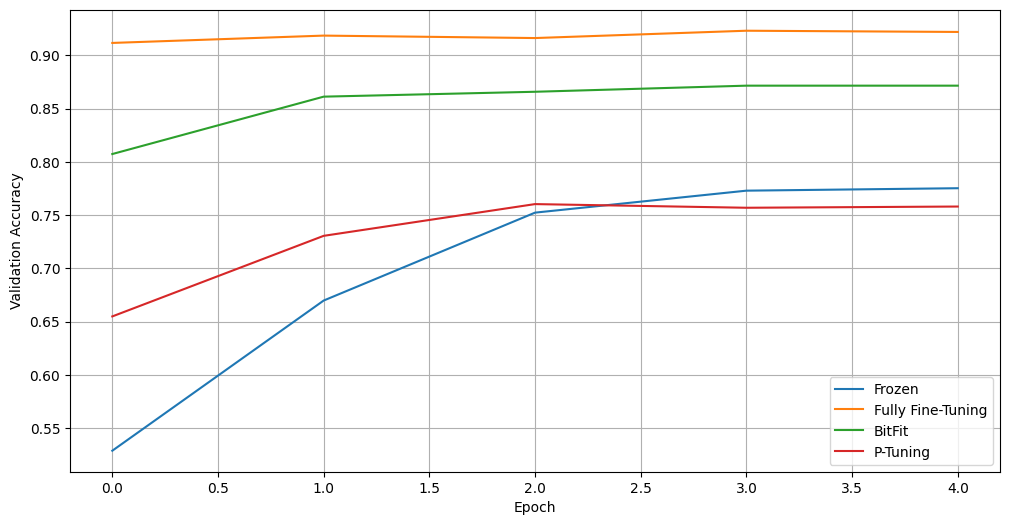

In [29]:
plot_training_record(training_record, metric_name="val_acc")

In [30]:
# 定义一个继承自nn.Module的类，用于前缀调优的BERT模型
class PrefixTuningBert(nn.Module):
    def __init__(self, num_virtual_tokens=20, prefix_projection=True):
        super().__init__()  # 调用父类的初始化方法
        # 加载预训练的BERT模型
        self.model = AutoModel.from_pretrained("bert-base-uncased")
        # 添加一个线性分类层
        self.classifier = nn.Linear(self.model.config.hidden_size, 1)

        # 冻结预训练模型的参数，只训练分类器层
        for param in self.model.parameters():
            param.requires_grad = False

        # 前缀相关的参数
        self.num_virtual_tokens = num_virtual_tokens  # 虚拟token的数量
        self.prefix_projection = prefix_projection  # 是否使用前缀投影
        hidden_size = self.model.config.hidden_size  # 隐藏层大小 768
        self.num_layers = self.model.config.num_hidden_layers  # Transformer层数,12层
        self.num_attention_heads = self.model.config.num_attention_heads  # 注意力头数 12
        self.embed_size_per_head = hidden_size // self.num_attention_heads  # 每个头的嵌入大小 768 // 12 = 64

        # 如果使用前缀投影
        if self.prefix_projection: # prefix
            self.prefix_tokens = nn.Parameter(torch.zeros(self.num_virtual_tokens, hidden_size))
            self.transform = torch.nn.Sequential(
                torch.nn.Linear(hidden_size, hidden_size), 
                torch.nn.Tanh(),  # 使用tanh激活函数
                torch.nn.Linear(hidden_size, self.num_layers * 2 * hidden_size),  # self.num_layers * 2, 因为每一层token需要同时拼接到 k 和 v 上
            )
        else: # p-tuning v2
            self.prefix_tokens = nn.Parameter(torch.zeros(self.num_virtual_tokens, self.num_layers * 2 * hidden_size))

    def forward(self, input_ids, attention_mask, **args):
        # 将前缀token投影并分割为key和value
        batch_size = input_ids.size(0) #获得批次大小
        prefix_tokens = self.prefix_tokens.unsqueeze(0).expand(batch_size, -1, -1)#变为（bs,num_virtual_tokens,768）
        if self.prefix_projection:
            past_key_values = self.transform(prefix_tokens) #输出的形状为(batch_size, 20, self.num_layers * 2 * hidden_size)
        else:
            past_key_values = prefix_tokens

        # 改变形状以适配Transformer的输入格式
        # print(past_key_values.shape)
        #(batch_size, self.num_layers, 2, self.num_attention_heads, -1, self.embed_size_per_head)
        past_key_values = past_key_values.view(batch_size, self.num_layers, 2, self.num_attention_heads, -1, self.embed_size_per_head)
        # print(past_key_values.shape) #shape值为torch.Size([32, 12, 2, 12, 20, 64])
        # 重新排列维度以适配Transformer的输入格式
        #(2，self.num_layers,batch_size, self.num_attention_heads, -1, self.embed_size_per_head)
        past_key_values = past_key_values.permute(2, 1, 0, 3, 4, 5)
        # 分离成多个包含key和value的元组，每个元组对应一层Transformer
        past_key_values = tuple([tuple([past_key_values[0][i], past_key_values[1][i]]) for i in range(self.num_layers)])

        # 修改注意力掩码，包含前缀token
        extended_attention_mask = torch.cat([
            torch.ones(batch_size, self.num_virtual_tokens).to(attention_mask.device),  # 前缀的注意力掩码
            attention_mask
            ], dim=1)

        # 将数据输入到BERT模型中,传入past_key_values
        outputs = self.model(input_ids, extended_attention_mask, past_key_values=past_key_values)

        feature = outputs.last_hidden_state[:, 0, :]  # 获取[CLS] token的特征表示

        # 使用分类层进行分类
        logits = self.classifier(feature)

        # 返回sigmoid激活后的logits
        return torch.sigmoid(logits).squeeze()

# 创建前缀调优BERT模型实例
prefix_tuning_bert = PrefixTuningBert()
# print(prefix_tuning_bert)
# 计算模型参数数量
count_parameters(prefix_tuning_bert)



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total Parameters:	 124.26M
Frozen Parameters:	 109.48M
Trainable Parameters:	  14.78M	11.89%


In [ ]:
training_record["Prefix Tuning"] = train(prefix_tuning_bert, train_loader, val_loader, device, num_epochs=num_epochs, patience=patience)

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 0: train_loss 0.6874, train_acc 0.5232, val_loss 0.6330, val_acc 0.6651
epoch 1: train_loss 0.3567, train_acc 0.8495, val_loss 0.3243, val_acc 0.8635
epoch 2: train_loss 0.3027, train_acc 0.8728, val_loss 0.3037, val_acc 0.8784
epoch 3: train_loss 0.2907, train_acc 0.8780, val_loss 0.2972, val_acc 0.8796
epoch 4: train_loss 0.2868, train_acc 0.8806, val_loss 0.2976, val_acc 0.8807


In [32]:
del prefix_tuning_bert

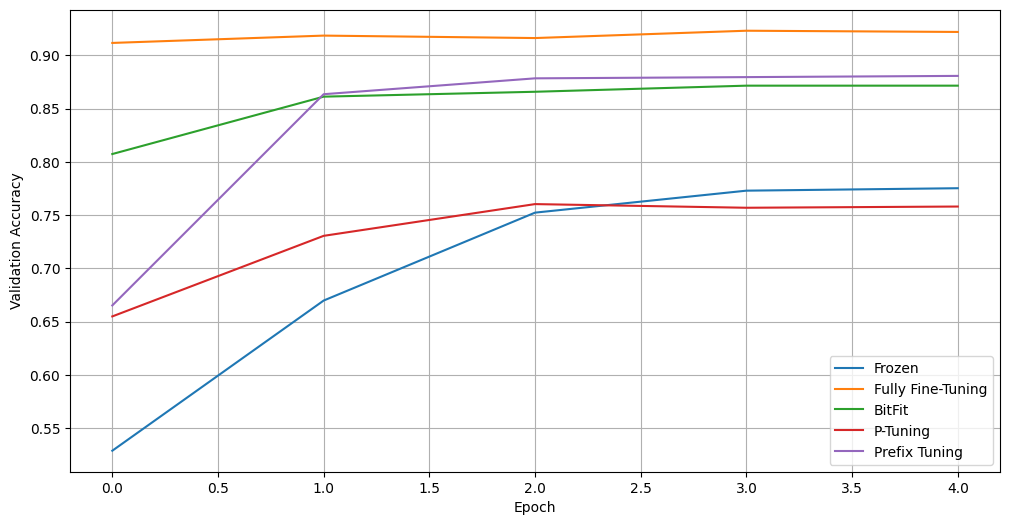

In [34]:
plot_training_record(training_record, metric_name="val_acc")

In [35]:
# 创建P-Tuning v2 BERT模型实例
p_tuning_v2_bert = PrefixTuningBert(prefix_projection=False)
print(p_tuning_v2_bert)

print(f'Total trainable parameters: {count_parameters(p_tuning_v2_bert)}')


training_record["P-Tuning v2"] = train(p_tuning_v2_bert, train_loader, val_loader, device, num_epochs=num_epochs, patience=patience)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


PrefixTuningBert(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 0: train_loss 0.6996, train_acc 0.4919, val_loss 0.6904, val_acc 0.5103
epoch 1: train_loss 0.6627, train_acc 0.5816, val_loss 0.6574, val_acc 0.6307
epoch 2: train_loss 0.6286, train_acc 0.6586, val_loss 0.6278, val_acc 0.7523
epoch 3: train_loss 0.6027, train_acc 0.7237, val_loss 0.6128, val_acc 0.7913
epoch 4: train_loss 0.5942, train_acc 0.7390, val_loss 0.6103, val_acc 0.7936


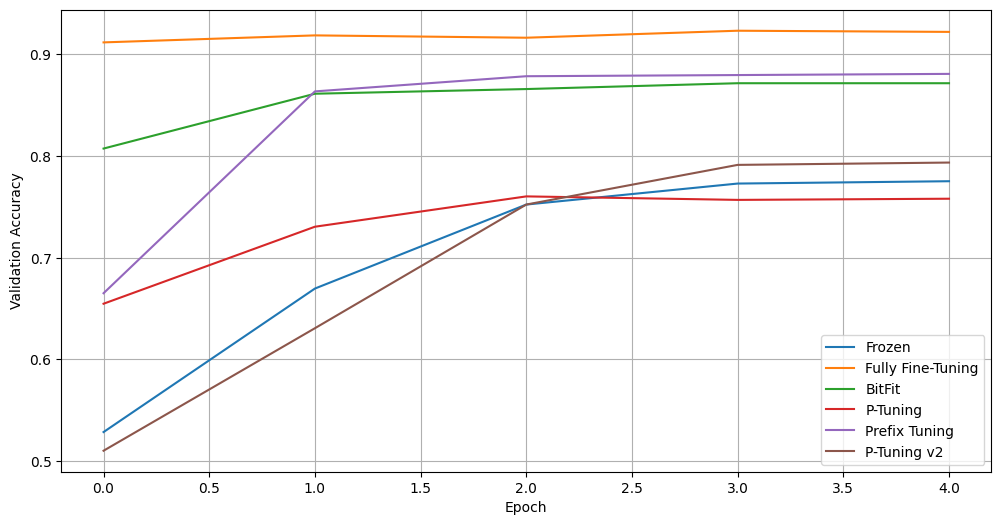

In [36]:
plot_training_record(training_record, metric_name="val_acc")

## LoRA

LoRA（论文：LoRA: LOW-RANK ADAPTATION OF LARGE LANGUAGE MODELS），该方法的核心思想就是通过低秩分解来模拟参数的改变量，从而以极小的参数量来实现大模型的间接训练。

在涉及到矩阵相乘的模块，在原始的PLM旁边增加一个新的通路，通过前后两个矩阵A,B相乘，第一个矩阵A负责降维，第二个矩阵B负责升维，中间层维度为r，从而来模拟所谓的本征秩（intrinsic rank）。

rank的作用：
rank代表低秩矩阵的秩，即线性变换矩阵A和B的输出特征数量。在LoRA中，原始的高维特征通过线性变换A被映射到一个低维空间（rank维），然后再通过另一个线性变换B映射回原始特征空间。较低的rank值意味着更少的参数需要更新，从而降低了模型复杂度和计算成本。

lora_alpha的作用：
lora_alpha是一个缩放因子，用于调整LoRA输出的贡献。它通过除以rank来计算得到scaling，这个缩放因子被用于控制低秩空间中的特征对最终输出的贡献度。较大的lora_alpha值会增加LoRA特征的影响力，而较小的值则会减少其影响。

In [38]:
import torch
import torch.nn as nn
from transformers import AutoModel
# 其他必要的导入语句可能在这里，例如用于训练的优化器、损失函数等。

# 定义LoRALayer类，它继承自PyTorch的nn.Module
class LoRALayer(nn.Module):
    # 初始化函数
    def __init__(self, module: nn.Module, rank: int = 1, lora_alpha: int = 1):
        # 调用父类的初始化函数
        super().__init__()
        # 确保输入的rank是正整数
        assert isinstance(rank, int) and rank > 1, "Lora rank should be a positive integer"

        # 计算缩放因子
        self.scaling = lora_alpha / rank
        # 存储传入的模块
        self.module = module
        # 定义从输入特征到rank维空间的线性变换A
        self.A = nn.Linear(module.in_features, rank, bias=False)
        # 定义从rank维空间到输出特征的线性变换B
        self.B = nn.Linear(rank, module.out_features, bias=False)
        # 使用Kaiming均匀初始化方法初始化A的权重,超参可选
        nn.init.kaiming_uniform_(self.A.weight, a=5 ** 0.5)
        # 将B的权重初始化为0，超参可选
        nn.init.zeros_(self.B.weight)
        # 将A和B移动到与模块权重相同的设备上
        self.A.to(device=module.weight.device)
        self.B.to(device=module.weight.device)

    # 前向传播函数
    def forward(self, inputs, *args, **kwargs):
        # 首先通过原始模块进行前向传播
        with torch.no_grad():  # 确保这个操作不会影响梯度计算
            outputs = self.module(inputs, *args, **kwargs)
        # 计算LoRA的输出并加到原始模块的输出上
        return outputs + self.B(self.A(inputs)) * self.scaling

# 定义LoRABert类，它也继承自PyTorch的nn.Module
class LoRABert(nn.Module):
    # 初始化函数
    def __init__(self, rank=8, lora_alpha=32):
        # 调用父类的初始化函数
        super().__init__()
        # 加载预训练的BERT模型
        self.model = AutoModel.from_pretrained("bert-base-uncased")
        # 应用LoRA技术到BERT模型的查询投影和键投影
        self._apply_lora(rank=rank, lora_alpha=lora_alpha)
        # 定义一个线性分类器，用于最后的任务分类
        self.classifier = nn.Linear(self.model.config.hidden_size, 1)

    # 应用LoRA到BERT模型的辅助函数,把self.model换掉了
    def _apply_lora(self, rank, lora_alpha):
        # 冻结预训练模型的参数
        for param in self.model.parameters():
            param.requires_grad = False
        # 对BERT模型中的每一层应用LoRA，children()可以拿到每层的层对象,也可以换V和O，这就是超参
        for layer in self.model.encoder.layer.children(): # 替换掉对应的层, q, k ,v 都可以替换
            layer.attention.self.query = LoRALayer(layer.attention.self.query, rank=rank, lora_alpha=lora_alpha) 
            layer.attention.self.key = LoRALayer(layer.attention.self.key, rank=rank, lora_alpha=lora_alpha)

    # 前向传播函数
    def forward(self, input_ids, attention_mask, token_type_ids):
        # 通过BERT模型进行前向传播
        outputs = self.model(input_ids, attention_mask, token_type_ids)
        # 提取[CLS]标记的表示作为特征
        feature = outputs.last_hidden_state[:, 0, :]
        # 使用分类器生成logits
        logits = self.classifier(feature)
        # 应用sigmoid激活函数得到最终的输出
        return torch.sigmoid(logits).squeeze()

# 实例化LoRABert模型
lora_bert = LoRABert(rank=8,lora_alpha=32)
print(lora_bert)
# 假设count_parameters是一个函数，用于计算并打印模型的参数数量
count_parameters(lora_bert)



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


LoRABert(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): LoRALayer(
                (module): Linear(in_features=768, out_features=768, bias=True)
                (A): Linear(in_features=768, out_features=8, bias=False)
                (B): Linear(in_features=8, out_features=768, bias=False)
              )
              (key): LoRALayer(
                (module): Linear(in_features=768, out_features=768, bias=True)
                (A): Linear(in_features=768, out_features=8, bias=False)
                (B): Line

In [ ]:
training_record["LoRA"] = train(lora_bert, train_loader, val_loader, device, num_epochs=num_epochs, patience=patience)

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 0: train_loss 0.6414, train_acc 0.6284, val_loss 0.4234, val_acc 0.8498
epoch 1: train_loss 0.3670, train_acc 0.8530, val_loss 0.3097, val_acc 0.8727
epoch 2: train_loss 0.3175, train_acc 0.8685, val_loss 0.2881, val_acc 0.8796
epoch 3: train_loss 0.3080, train_acc 0.8719, val_loss 0.2815, val_acc 0.8842
epoch 4: train_loss 0.3036, train_acc 0.8729, val_loss 0.2797, val_acc 0.8865


In [40]:
del lora_bert

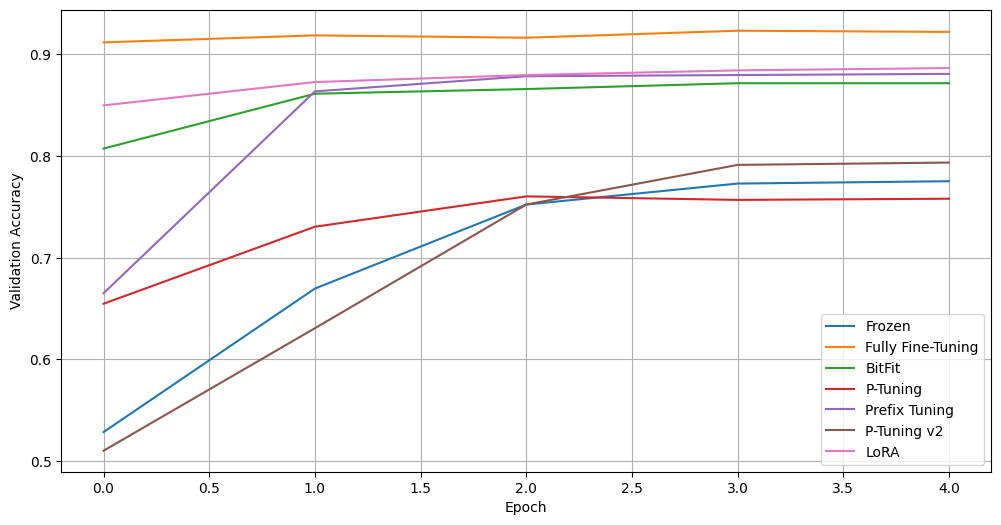

In [41]:
plot_training_record(training_record, metric_name="val_acc")

## Adapter Tuning

Adapter Tuning（论文：Parameter-Efficient Transfer Learning for NLP），该方法设计了Adapter结构，并将其嵌入Transformer的结构里面，针对每一个Transformer层，增加了两个Adapter结构(分别是多头注意力的投影之后和第二个feed-forward层之后)，在训练时，固定住原来预训练模型的参数不变，只对新增的 Adapter 结构和 Layer Norm 层进行微调，从而保证了训练的高效性。

In [ ]:
class AdapterLayer(nn.Module):
    def __init__(self, input_size, adapter_size):
        super().__init__()
        # 第一个线性层，将输入特征从 input_size 维度降低到 adapter_size 维度
        self.down_project = nn.Linear(input_size, adapter_size)
        # ReLU 激活函数
        self.nolinearity = nn.ReLU()
        # 第二个线性层，将适配器层的特征从 adapter_size 维度恢复到原始维度
        self.up_project = nn.Linear(adapter_size, input_size)

    def forward(self, x):
        # 适配器层的前向传播
        return self.up_project(self.nolinearity(self.down_project(x)))


class BertSelfOutput(nn.Module):
    # 自注意力层的输出部分
    def __init__(self, config, adapter_size):
        super().__init__()
        # 原始的全连接层
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        # 原始的LayerNorm(层归一化) 层
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        # 原始的 Dropout 层
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        # 插入的适配器层
        self.adapter = AdapterLayer(config.hidden_size, adapter_size)

    def forward(self, hidden_states: torch.Tensor, input_tensor: torch.Tensor) -> torch.Tensor:
        # 自注意力层的输出前向传播
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.adapter(hidden_states) #把自己写的adapter给串进去
        hidden_states = self.LayerNorm(hidden_states + input_tensor) #加号代表残差连接
        return hidden_states

class BertOutput(nn.Module):
    # 输出层
    def __init__(self, config, adapter_size):
        super().__init__()
        # 原始的全连接层
        # print(config.intermediate_size) #3072
        self.dense = nn.Linear(config.intermediate_size, config.hidden_size)
        # LayerNorm 层
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        # Dropout 层
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        # 插入的适配器层
        self.adapter = AdapterLayer(config.hidden_size, adapter_size)

    def forward(self, hidden_states: torch.Tensor, input_tensor: torch.Tensor) -> torch.Tensor:
        # 输出层的前向传播
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.adapter(hidden_states) #把adapter放入原有的层中间
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states


class AdapterBert(nn.Module):
    def __init__(self, adapter_size=64):
        super().__init__()
        # 加载预训练的BERT模型
        self.model = AutoModel.from_pretrained("bert-base-uncased")
        # 获取预训练模型的状态字典，为什么要提前保存，是因为原有的层被覆盖的问题
        pretrained_state_dict = self.model.state_dict()
        # print(self.model.config)
        # 添加一个线性分类器
        self.classifier = nn.Linear(self.model.config.hidden_size, 1)

        # 为模型的每层应用适配器，把模型对应的BertSelfOutput和BertOutput覆盖
        self._apply_adapter(adapter_size=adapter_size)

        # 修改预训练状态字典，将适配器层的参数加入  --------重要--------
        for name, param in self.model.named_parameters():
            if "adapter" in name:
                pretrained_state_dict[name] = param #把adapter层放进去
        # 加载修改后的状态字典
        self.model.load_state_dict(pretrained_state_dict)

        # 冻结除适配器层以外的所有参数
        for name, param in self.model.named_parameters():
            if "adapter" not in name:
                param.requires_grad = False

        # 删除不再使用的预训练状态字典
        del pretrained_state_dict

    def _apply_adapter(self, adapter_size):
        # 为BERT模型的每层应用适配器层，总计12层
        for layer in self.model.encoder.layer:
            layer.attention.output = BertSelfOutput(self.model.config, adapter_size) #BertSelfOutput输出层重写,名字是完全对应的
            layer.output = BertOutput(self.model.config, adapter_size) #BertOutput层重写，名字是完全对应的

    def forward(self, input_ids, attention_mask, token_type_ids):
        # 模型的前向传播
        outputs = self.model(input_ids, attention_mask, token_type_ids)
        # 提取[CLS]标记的表示作为特征
        feature = outputs.last_hidden_state[:, 0, :]
        # 使用分类器生成logits
        logits = self.classifier(feature)
        # 应用sigmoid激活函数得到最终的输出
        return torch.sigmoid(logits).squeeze()


# 实例化适配器BERT模型
adapter_bert = AdapterBert(adapter_size=64)
print('-'*50)
print(adapter_bert)
print('-'*50)
# 计算模型参数
count_parameters(adapter_bert)



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


--------------------------------------------------
AdapterBert(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

: 

In [ ]:
training_record["Adapter Tuning"] = train(adapter_bert, train_loader, val_loader, device, num_epochs=num_epochs, patience=patience)

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 0: train_loss 0.6271, train_acc 0.5966, val_loss 0.5052, val_acc 0.7661
epoch 1: train_loss 0.4087, train_acc 0.8134, val_loss 0.4612, val_acc 0.7890
epoch 2: train_loss 0.3686, train_acc 0.8362, val_loss 0.4380, val_acc 0.8028
epoch 3: train_loss 0.3518, train_acc 0.8463, val_loss 0.4242, val_acc 0.8016
epoch 4: train_loss 0.3442, train_acc 0.8499, val_loss 0.4229, val_acc 0.8028


In [44]:
del adapter_bert

## Plot

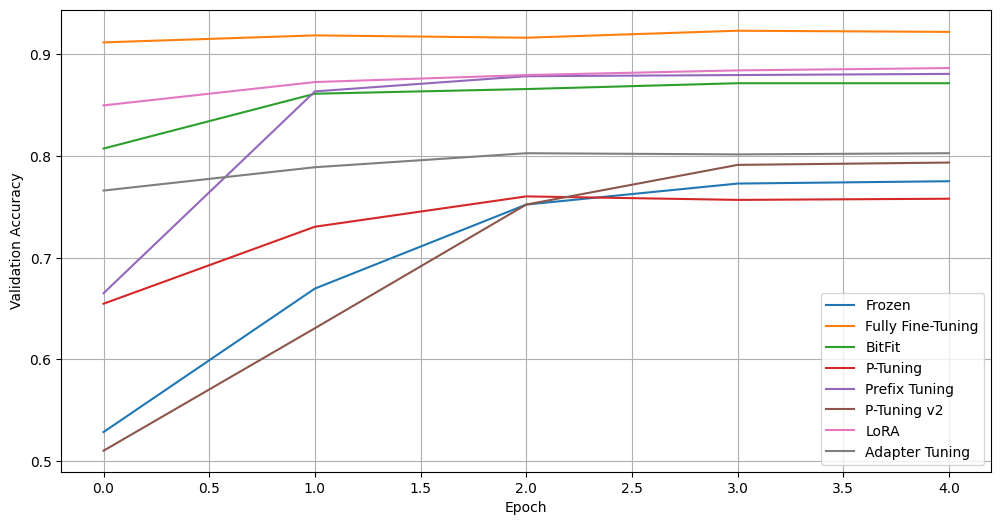

In [45]:

plot_training_record(training_record, metric_name="val_acc")